In [ ]:
# Data Normalization for distance-based models
# 88.52% Accuracy

# PCA Idea from Saswat Tulo: 
# https://www.kaggle.com/code/saswattulo/heart-disease-prediction-with-89-47-accuracy

In [277]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.inspection import permutation_importance
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb

In [228]:
data_dir = '/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv'
df = pd.read_csv(data_dir)

In [229]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [230]:
df.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [231]:
continuous_features = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall']
target = 'output'

# NORMALIZATION

In [232]:
scaler = MinMaxScaler()
df[continuous_features] = scaler.fit_transform(df[continuous_features])

In [233]:
X = df.drop(target, axis=1)  
y = df[target]  

# MODELS

In [234]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [216]:
def train_and_evaluate_models(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators = 200,
                                                criterion = 'log_loss',
                                                random_state=42),
        'Support Vector Classifier': SVC(kernel = 'poly',
                                      gamma='scale',
                                      random_state=42),
        'XGBoost': XGBClassifier(use_label_encoder=False,
                                 max_depth = 30,
                                 eval_metric='logloss',
                                 random_state=42)
    }
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        print(f'{name} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}')

In [217]:
train_and_evaluate_models(X, y)

Logistic Regression - Accuracy: 0.8361, F1 Score: 0.8362
Decision Tree - Accuracy: 0.7541, F1 Score: 0.7522
Random Forest - Accuracy: 0.8361, F1 Score: 0.8361
Support Vector Classifier - Accuracy: 0.8689, F1 Score: 0.8685
XGBoost - Accuracy: 0.8197, F1 Score: 0.8197


# SVC GridSearch

In [205]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
param_grid = {
    'C': [0.1, 1, 10, 50, 100],  
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1, 10],  
    'degree': [2, 3, 4], 
    'coef0': [0.0, 0.5, 1.0] 
}

svc = SVC()

grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_parameters}")
print(f"Best Score: {best_score}")

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
Best Parameters: {'C': 10, 'coef0': 0.5, 'degree': 2, 'gamma': 0.01, 'kernel': 'sigmoid'}
Best Score: 0.83078231292517


In [207]:
best_model = SVC(**best_parameters)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set: ", accuracy)

Accuracy on test set:  0.8524590163934426


# Random Forest GridSearch

In [249]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [10, 50, 100, 200],  
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4]  
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test set accuracy: ", accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Best score:  0.8391156462585034
Test set accuracy:  0.8524590163934426


In [210]:
# Standard scaler instead of MinMax Scaler

df1 = pd.read_csv(data_dir)
scaler = StandardScaler()
df1[continuous_features] = scaler.fit_transform(df1[continuous_features])
X1 = df1.drop(target, axis=1)  
y1 = df1[target]  
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [10, 50, 100, 200],  
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4]  
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test set accuracy: ", accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Best score:  0.8391156462585034
Test set accuracy:  0.8524590163934426


# XGB Classifier 

In [244]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [3, 10, 20, 30],  
    'min_child_weight': [1, 2, 4], 
    'learning_rate': [0.01, 0.1, 0.2, 0.3]
}

grid_search = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), param_grid, cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test set accuracy: ", accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best parameters found:  {'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 50}
Best score:  0.8264455782312925
Test set accuracy:  0.8688524590163934


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


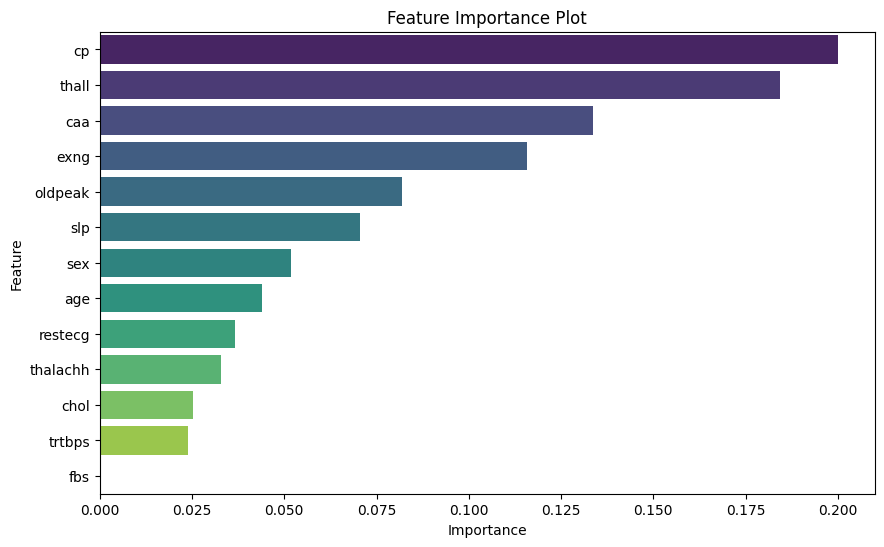

In [248]:
feature_importances = best_model.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]

sorted_features = [X_train.columns[i] for i in sorted_indices]

sorted_importances = feature_importances[sorted_indices]

plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importances, y=sorted_features, palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.show()

# KNN GridSearch

In [270]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_neighbors': [3, 5, 7, 10],  
    'weights': ['uniform', 'distance'],  
    'metric': ['euclidean', 'manhattan', 'minkowski'] 
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test set accuracy: ", accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found:  {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Best score:  0.8348639455782312
Test set accuracy:  0.8688524590163934


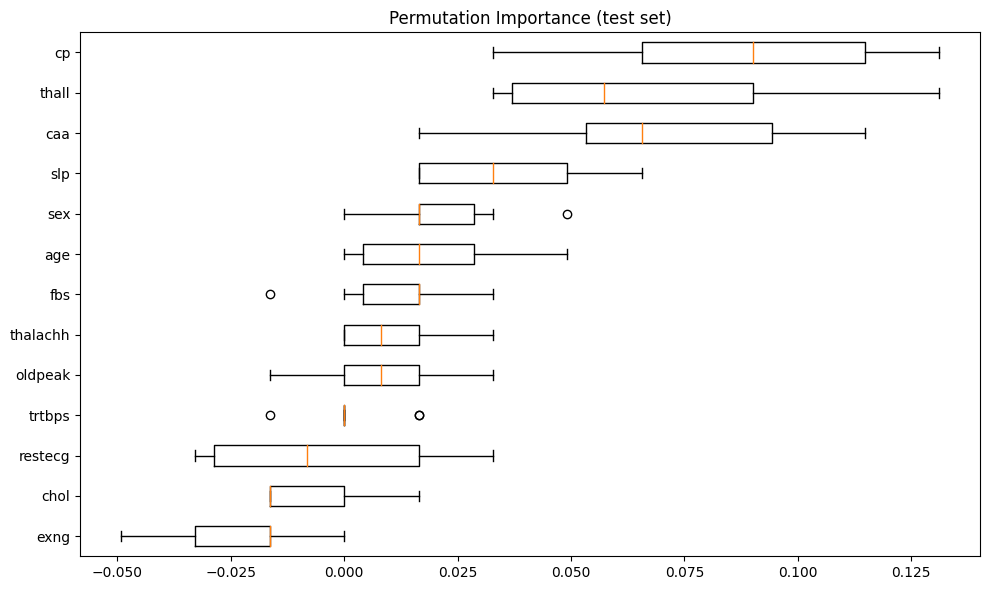

In [242]:
results = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = results.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.boxplot(results.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
plt.title("Permutation Importance (test set)")
plt.tight_layout()
plt.show()


In [243]:
# # Standard scaler instead of MinMax Scaler

# df1 = pd.read_csv(data_dir)
# scaler = StandardScaler()
# df1[continuous_features] = scaler.fit_transform(df1[continuous_features])
# X1 = df1.drop(target, axis=1)  
# y1 = df1[target]  
# X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

# param_grid = {
#     'n_neighbors': [3, 5, 7, 10],  
#     'weights': ['uniform', 'distance'],  
#     'metric': ['euclidean', 'manhattan', 'minkowski'] 
# }

# grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, verbose=1, n_jobs=-1)

# grid_search.fit(X_train, y_train)

# print("Best parameters found: ", grid_search.best_params_)
# print("Best score: ", grid_search.best_score_)

# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)
# print("Test set accuracy: ", accuracy_score(y_test, y_pred))

# Logistic Regression GridSearch

In [276]:
# IDEA FROM https://www.kaggle.com/code/saswattulo/heart-disease-prediction-with-89-47-accuracy

df1 = pd.read_csv(data_dir)
scaler = StandardScaler()
df1[continuous_features] = scaler.fit_transform(df1[continuous_features])
X1 = df1.drop(target, axis=1)  
y1 = df1[target]  
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

pca = PCA()
logistic_regression = LogisticRegression(random_state=42)

param_grid = {
    'pca__n_components': [5, 10, 12],  
    'logistic__C': [0.001, 0.01, 0.1, 1, 10],  
}

from sklearn.pipeline import Pipeline
pipe = Pipeline([
    ('pca', pca),
    ('logistic', logistic_regression)
])

grid_search = GridSearchCV(pipe, param_grid, cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy with PCA and logistic regression: ", accuracy)


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters found:  {'logistic__C': 10, 'pca__n_components': 10}
Best score:  0.8429421768707483
Test set accuracy with PCA and logistic regression:  0.8852459016393442


# Naive Bayes GridSearch

In [281]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

naive_bayes_model = GaussianNB()
naive_bayes_model.fit(X_train, y_train)

y_pred = naive_bayes_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy with Gaussian Naive Bayes: ", accuracy)

Test set accuracy with Gaussian Naive Bayes:  0.8688524590163934
